In [1]:
import os
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

spark = SparkSession.builder.appName("Diabetic Retinopathy: Spark model training").master("spark://spark-master:7077").config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/18 15:56:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def load_data(spark):
    # Charger les données

    train = spark.read.parquet('/home/data/processed/train')
    val = spark.read.parquet('/home/data/processed/val')
    test = spark.read.parquet('/home/data/processed/test')
    
    return train, val, test

In [3]:
def train_logistic_regression(train_data, val_data):
    # Normalisation
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    
    # Modèle de régression logistique
    lr = LogisticRegression(
        featuresCol="scaledFeatures",
        labelCol="label",
        maxIter=100,
        regParam=0.01,
        elasticNetParam=0.5
    )
    
    pipeline = Pipeline(stages=[scaler, lr])
    
    # Grille de paramètres
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()
    
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3
    )
    start_time = datetime.now()
    cv_model = cv.fit(train_data)
    end_time = datetime.now()
    
    best_model = cv_model.bestModel
    # Évaluation
    val_predictions = best_model.transform(val_data)
    val_auc = evaluator.evaluate(val_predictions)
    training_time = (end_time - start_time).total_seconds()

    print(f"AUC sur l'ensemble de validation: {val_auc:.4f}")
    
    return best_model, training_time

In [4]:
def train_random_forest(train_data, val_data):
    # Normalisation
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    
    # Modèle Random Forest
    rf = RandomForestClassifier(
        featuresCol="scaledFeatures",
        labelCol="label",
        numTrees=50,
        maxDepth=7,
        seed=42
    )
    
    # Pipeline
    pipeline = Pipeline(stages=[scaler, rf])
    
    # Grille de paramètres
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50]) \
        .addGrid(rf.maxDepth, [5, 7]) \
        .build()
    
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3
    )
    start_time = datetime.now()
    cv_model = cv.fit(train_data)
    end_time = datetime.now()
    
    best_model = cv_model.bestModel
    
    val_predictions = best_model.transform(val_data)
    val_auc = evaluator.evaluate(val_predictions)
    training_time = (end_time - start_time).total_seconds()

    print(f"AUC sur l'ensemble de validation: {val_auc:.4f}")
    return best_model, training_time

In [5]:
def train_svm(train_data, val_data):
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    
    svm = LinearSVC(
        featuresCol="scaledFeatures",
        labelCol="label",
        maxIter=50,
        regParam=0.3,
        tol=1e-4,
        aggregationDepth=2,
        standardization=False
    )
    
    pipeline = Pipeline(stages=[scaler, svm])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(svm.regParam, [0.3]) \
        .addGrid(svm.maxIter, [30]) \
        .build()
    
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3
    )
    start_time = datetime.now()
    cv_model = cv.fit(train_data)
    end_time = datetime.now()
    best_model = cv_model.bestModel
        
    val_predictions = best_model.transform(val_data)
    val_auc = evaluator.evaluate(val_predictions)
    training_time = (end_time - start_time).total_seconds()

    print(f"AUC sur l'ensemble de validation: {val_auc:.4f}")
        
    return best_model, training_time
        

In [6]:
def evaluate_model(model, test_data, model_name):
    predictions = model.transform(test_data)
    
    binary_evaluator = BinaryClassificationEvaluator(labelCol="label")
    multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    
    auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
    
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Matrice de confusion
    pred_and_labels = predictions.select("prediction", "label").toPandas()
    y_true = pred_and_labels["label"].values
    y_pred = pred_and_labels["prediction"].values
    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nMatrice de confusion:")
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Négatif (0)', 'Positif (1-4)'],
                yticklabels=['Négatif (0)', 'Positif (1-4)'])
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    
    return metrics, predictions

In [7]:
def save_model(model, model_name):
    path = f"/home/models/spark_{model_name}"
    model.write().overwrite().save(path)
    print(f"Modèle sauvegardé: {path}")

In [8]:
def visualize_results(results_df):
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        results_df.plot(x='model', y=metric, kind='bar', ax=ax, legend=False)
        ax.set_title(f'{metric.upper()}')
        ax.set_xlabel('Modèle')
        ax.set_ylabel('Score')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', alpha=0.3)
    
    axes[-1].axis('off')
    
    plt.tight_layout()
    plt.close()

In [9]:
train, val, test = load_data(spark)

In [10]:
results = []
models = {}

25/12/18 15:56:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


AUC sur l'ensemble de validation: 0.9634
Accuracy: 0.9018
Precision: 0.9028
Recall: 0.9018
F1-Score: 0.9018
AUC-ROC: 0.9585


/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



Matrice de confusion:
[[636  53]
 [ 86 640]]
Modèle sauvegardé: /home/models/spark_logistic_regression


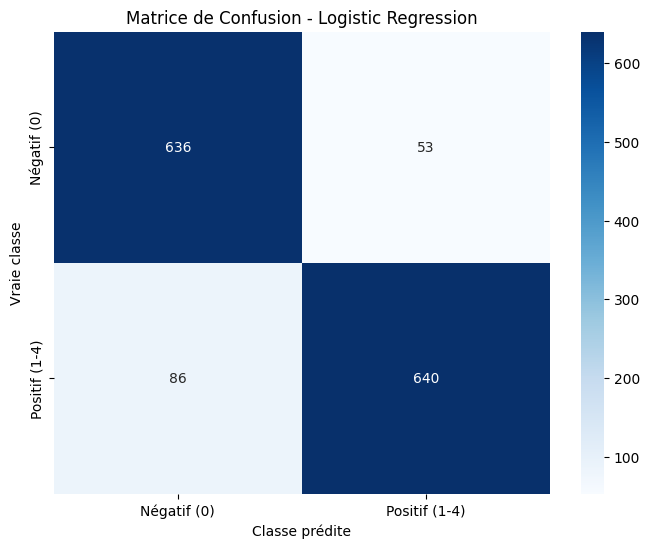

In [11]:
# Logistic Regression
lr_model, lr_time = train_logistic_regression(train, val)
lr_metrics, _ = evaluate_model(lr_model, test, "Logistic Regression")
lr_metrics['training_time'] = lr_time
results.append(lr_metrics)
models['logistic_regression'] = lr_model
save_model(lr_model, "logistic_regression")

AUC sur l'ensemble de validation: 0.9893
Accuracy: 0.9527
Precision: 0.9527
Recall: 0.9527
F1-Score: 0.9527
AUC-ROC: 0.9874

Matrice de confusion:
[[659  30]
 [ 37 689]]


/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Modèle sauvegardé: /home/models/spark_random_forest


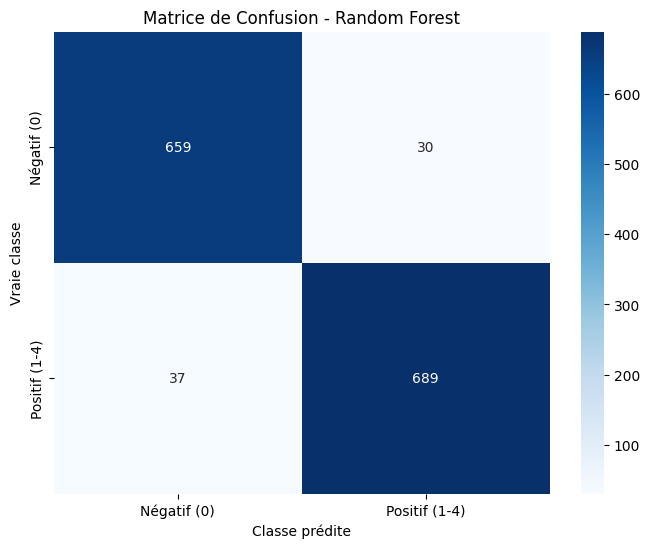

In [12]:
# Random Forest
rf_model,rf_time = train_random_forest(train, val)
rf_metrics, _ = evaluate_model(rf_model, test, "Random Forest")
rf_metrics['training_time'] = rf_time
results.append(rf_metrics)
models['random_forest'] = rf_model
save_model(rf_model, "random_forest")

AUC sur l'ensemble de validation: 0.9422
Accuracy: 0.8615
Precision: 0.8634
Recall: 0.8615
F1-Score: 0.8614
AUC-ROC: 0.9391

Matrice de confusion:
[[615  74]
 [122 604]]


/opt/spark/python/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Modèle sauvegardé: /home/models/spark_svm


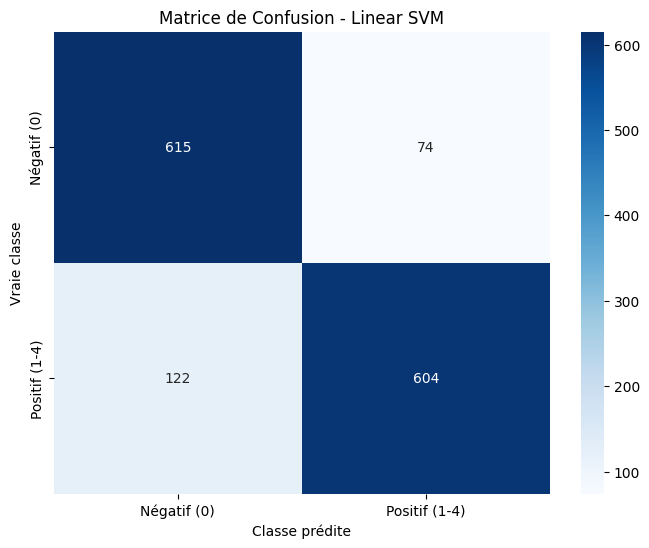

In [13]:
# SVM
svm_model,svm_time = train_svm(train, val)
svm_metrics, _ = evaluate_model(svm_model, test, "Linear SVM")
svm_metrics['training_time'] = svm_time
results.append(svm_metrics)
models['svm'] = svm_model
save_model(svm_model, "svm")

In [14]:
# Créer un DataFrame des résultats
results_df = pd.DataFrame(results)
        
# Sauvegarder les résultats
results_df.to_csv('/home/models/spark_results.csv', index=False)
print("\nRésultats sauvegardés: /home/models/spark_results.csv")
        
# Visualiser
visualize_results(results_df)


Résultats sauvegardés: /home/models/spark_results.csv


In [15]:
spark.stop()